In [69]:
import xarray as xr
import numpy as np 
import os
import matplotlib.pyplot as plt
import pandas as pd

from src.models.models_util import CESM_Dataset
from src.experiment_configs import config1 as config
from src.experiment_configs import config2
from torch.utils.data import DataLoader
from src.utils import util_cesm
from src import config_cesm
from src.models import models
from src.models import models_util

reference_grid = util_cesm.generate_sps_grid()

def get_ensemble_members_and_time_coords(data_split_settings, split):
    if data_split_settings["split_by"] == "ensemble_member":
        ensemble_members = data_split_settings[split]
        time_coords = data_split_settings["time_range"]
    elif data_split_settings["split_by"] == "time":
        ensemble_members = data_split_settings["member_ids"]
        time_coords = data_split_settings[split]

    return ensemble_members, time_coords

def get_targets(data_split_settings, split):
    """
    Returns:
        (xr.DataArray)  targets 
    """

    ensemble_members, time_coords = get_ensemble_members_and_time_coords(data_split_settings, split)

    data_dir = os.path.join(config_cesm.PROCESSED_DATA_DIRECTORY, "data_pairs", data_split_settings["name"])

    ds_list = []
    for member_id in ensemble_members:
        ds = xr.open_dataset(os.path.join(data_dir, f"targets_member_{member_id}.nc"))
        ds_list.append(ds)

    targets = xr.concat(ds_list, dim="member_id")

    targets = targets.transpose("start_prediction_month", "member_id", "lead_time", "y", "x")

    return targets.data

def broadcast_climatology_like(data_split_settings, da):
    """
    Param:
        dict            this should have the name of the data_settings which specifies the climatology 
        xr.DataArray    prediction-like array that you want to broadcast climatology 
    
    Returns:
        xr.DataArray    climatology broadcasted
    """

    icefrac_mean = xr.open_dataset(f"{config_cesm.PROCESSED_DATA_DIRECTORY}/normalized_inputs/{data_split_settings["name"]}/icefrac_mean.nc").icefrac
    
    def calculate_month(start_month, lead_time):
        return (start_month + lead_time - 2) % 12 + 1

    pred_months = xr.apply_ufunc(
        calculate_month,
        da["start_prediction_month"].dt.month,
        da["lead_time"],
        vectorize=True,
        dask="allowed",
        output_dtypes=[int],
    )

    climatology_broadcasted = icefrac_mean.sel(month=pred_months).broadcast_like(da).drop_vars("month")

    return climatology_broadcasted


def add_climatology(da, climatology_broadcasted, clip=True):
    """
    Param:
        (xr.DataArray)  array of anomalies
        (xr.DataArray)  array of climatology that is the same shape as da
                        note: to do this you can run broadcast_climatology_like
        (bool)          possibly clip the anomalies to 

    Returns:
        (xr.DataArray)
    """
    # Add climatology back to the anomalies
    absolute_da = da + climatology_broadcasted

    # Clip the resulting values to [0, 1]
    if clip: absolute_da = absolute_da.clip(0, 1)

    return absolute_da

def remove_climatology(da, climatology_broadcasted):
    return da - climatology_broadcasted

def load_model_predictions(experiment_name, model, checkpoint):
    output_dir = os.path.join(config_cesm.PREDICTIONS_DIRECTORY, experiment_name)
    output_path = os.path.join(output_dir, f"{model}_{checkpoint}_predictions.nc")

    # get the model predictions (this is a DataArray)
    predictions = xr.open_dataset(output_path).predictions 

    return predictions 


In [72]:
predictions_config1 = load_model_predictions(config.EXPERIMENT_NAME, config.MODEL, config.CHECKPOINT_TO_EVALUATE)
predictions_config2 = load_model_predictions(config2.EXPERIMENT_NAME, config2.MODEL, config2.CHECKPOINT_TO_EVALUATE)

In [ ]:
# make anomaly persistence and climatology predictions (DataArrays)
anomaly_persistence_predictions = models.anomaly_persistence(config.DATA_SPLIT_SETTINGS, None).predictions
climatology_predictions = models.climatology_predictions(config.DATA_SPLIT_SETTINGS, None).predictions

targets = get_targets(config.DATA_SPLIT_SETTINGS, "test") # DataArray of targets

# get the broadcast climatology (this is a DataArray)
climatology_broadcasted = broadcast_climatology_like(config.DATA_SPLIT_SETTINGS, targets)

In [80]:
predictions1_absolute = add_climatology(predictions_config1, climatology_broadcasted)
predictions1_anom = remove_climatology(predictions1_absolute, climatology_broadcasted)

predictions2_absolute = add_climatology(predictions_config2, climatology_broadcasted)
predictions2_anom = remove_climatology(predictions2_absolute, climatology_broadcasted)

targets_absolute = add_climatology(targets, climatology_broadcasted)

persistence_anom = remove_climatology(anomaly_persistence_predictions, climatology_broadcasted)
climatology_anom = remove_climatology(climatology_predictions, climatology_broadcasted)



In [91]:
def calculate_integrated_area_error(predictions, targets):
    integrated_area_error = xr.DataArray(
        np.empty((config.MAX_LEAD_MONTHS,12)),
        dims = ("lead_time", "month")
    )

    for lead in range(config.MAX_LEAD_MONTHS):
        diff = np.abs(targets.isel(lead_time=lead) - predictions.isel(lead_time=lead))

        area_error = (diff * reference_grid.area).sum(("x","y"))

        integrated_area_error[lead,:] = area_error.groupby("start_prediction_month.month").mean(("start_prediction_month", "member_id"))

    icefrac_mean = xr.open_dataset(f"{config_cesm.PROCESSED_DATA_DIRECTORY}/normalized_inputs/{config.DATA_CONFIG_NAME}/icefrac_mean.nc").icefrac
    for month in range(12):
        mean_sia = (icefrac_mean.isel(month=month) * reference_grid.area).sum(("x","y"))
        integrated_area_error[:, month] /= mean_sia

    return integrated_area_error

def calculate_acc(predictions: xr.DataArray, 
                  truth: xr.DataArray, aggregate,
                  dim: str = "start_prediction_month") -> xr.DataArray:
    """
    Calculate the Anomaly Correlation Coefficient (ACC) between predictions and truth.

    Parameters:
    - predictions (xr.DataArray): Predictions (absolute, not anomalies) 
    - truth (xr.DataArray): True anomalies with dimensions including `dim`.
    - dim (str): The dimension over which to calculate the ACC. Default is "start_prediction_month".
    
    Returns:
    - xr.DataArray: ACC values with dimensions remaining after collapsing `dim`.
    """
    # Ensure dimensions match
    if predictions.dims != truth.dims:
        raise ValueError("Predictions and truth must have the same dimensions.")

    # Remove the mean along the specified dimension
    pred_anomaly = predictions - predictions.mean(dim)
    truth_anomaly = truth - truth.mean(dim)

    # Compute numerator (covariance)
    numerator = (pred_anomaly * truth_anomaly).mean(dim)

    # Compute denominator (product of standard deviations)
    pred_std = pred_anomaly.std(dim)
    truth_std = truth_anomaly.std(dim)
    denominator = pred_std * truth_std

    # Compute ACC
    acc = numerator / denominator

    if aggregate:
        if dim == ("x", "y"):
            acc = acc.mean('member_id').groupby("start_prediction_month.month").mean("start_prediction_month")

    return acc

## Illustration of ACC calculation
The anomaly correlation coefficient (ACC) can be calculated spatially (see e.g., https://confluence.ecmwf.int/display/FUG/Section+6.2.2+Anomaly+Correlation+Coefficient) or temporally. 

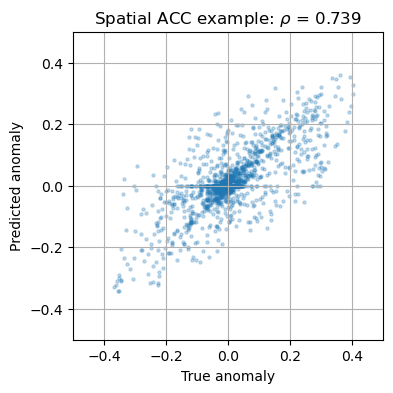

In [88]:
targets_subset = targets.isel(member_id=0, lead_time=0)
predictions_subset = predictions1_anom.isel(member_id=0, lead_time=0)

plt.figure(figsize=(4,4))
plt.scatter(targets_subset.isel(start_prediction_month=20).values.flatten(), 
            predictions_subset.isel(start_prediction_month=20).values.flatten(),
            s=5, alpha=0.25)
rho = np.corrcoef(targets_subset.isel(start_prediction_month=20).values.flatten(), 
                predictions_subset.isel(start_prediction_month=20).values.flatten())[0,1]
plt.xlim([-0.5, 0.5])
plt.ylim([-0.5, 0.5])
plt.grid(True)
plt.xlabel("True anomaly")
plt.ylabel("Predicted anomaly")
plt.title(rf"Spatial ACC example: $\rho$ = {np.round(rho, 3)}")
plt.savefig("figures/illustrations/ACC_calculation.jpg", dpi=300, bbox_inches="tight")

## Compute aggregated statistics

In [159]:
persistence_error = calculate_integrated_area_error(anomaly_persistence_predictions, targets_absolute)
ens_climatology_error = calculate_integrated_area_error(climatology_predictions, targets_absolute)
climatology_error = calculate_integrated_area_error(climatology_broadcasted, targets_absolute)

model1_error = calculate_integrated_area_error(predictions1_absolute, targets_absolute)
model2_error = calculate_integrated_area_error(predictions2_absolute, targets_absolute)

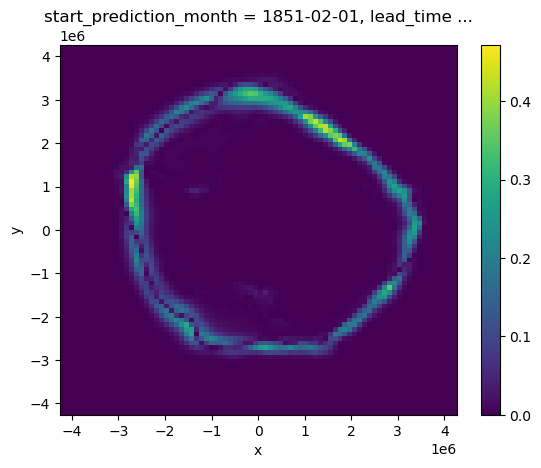

In [183]:
lead = 4
month = 1
diff = np.abs(climatology_broadcasted.isel(lead_time=lead) - targets_absolute.isel(lead_time=lead))
diff.isel(start_prediction_month=month, member_id=0).plot()

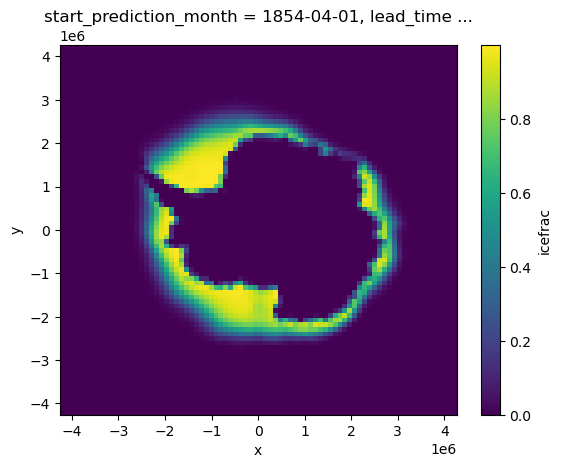

In [172]:
integrated_area_error = xr.DataArray(
    np.empty((config.MAX_LEAD_MONTHS,12)),
    dims = ("lead_time", "month")
)

for lead in range(config.MAX_LEAD_MONTHS):
    diff = np.abs(targets.isel(lead_time=lead) - predictions.isel(lead_time=lead))

    area_error = (diff * reference_grid.area).sum(("x","y"))

    integrated_area_error[lead,:] = area_error.groupby("start_prediction_month.month").mean(("start_prediction_month", "member_id"))

icefrac_mean = xr.open_dataset(f"{config_cesm.PROCESSED_DATA_DIRECTORY}/normalized_inputs/{config.DATA_CONFIG_NAME}/icefrac_mean.nc").icefrac
for month in range(12):
    mean_sia = (icefrac_mean.isel(month=month) * reference_grid.area).sum(("x","y"))
    integrated_area_error[:, month] /= mean_sia

In [98]:
model1_acc_spatial = calculate_acc(predictions1_anom, targets, dim=("x", "y"), aggregate=True) 
model2_acc_spatial = calculate_acc(predictions2_anom, targets, dim=("x", "y"), aggregate=True) 

persistence_acc_spatial = calculate_acc(persistence_anom, targets, dim=("x", "y"), aggregate=True) 
climatology_acc_spatial = calculate_acc(climatology_anom, targets, dim=("x", "y"), aggregate=True) 

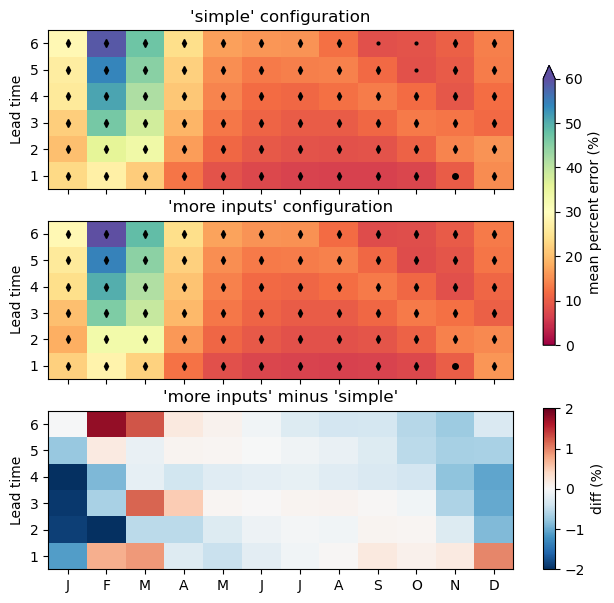

In [147]:
def plot_markers(ax, exceeds_persistence, exceeds_climatology, x_centers, y_centers):
    for i in range(6):
        for j in range(12):
            if exceeds_persistence[i,j] and exceeds_climatology[i,j]:
                ax.plot(x_centers[j], y_centers[i], 'dk', markersize=4) 
            elif exceeds_persistence[i,j]:
                ax.plot(x_centers[j], y_centers[i], '.k', markersize=4) 
            elif exceeds_climatology[i,j]:
                ax.plot(x_centers[j], y_centers[i], 'ok', markersize=4) 

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6,7), sharex=True)

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

exceeds_persistence = model1_error < persistence_error
exceeds_climatology = model1_error < climatology_error
cax = axs[0].pcolormesh(x, y, 100 * model1_error, cmap='Spectral', shading='flat', vmin=0, vmax=60)
axs[0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0].set_ylabel("Lead time")
axs[0].set_title(f"'simple' configuration")
plot_markers(axs[0], exceeds_persistence, exceeds_climatology, x_centers, y_centers)

exceeds_persistence = model2_error < persistence_error
exceeds_climatology = model2_error < climatology_error
axs[1].pcolormesh(x, y, 100 * model2_error, cmap='Spectral', shading='flat', vmin=0, vmax=60)
axs[1].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1].set_ylabel("Lead time")
axs[1].set_title("'more inputs' configuration")
plot_markers(axs[1], exceeds_persistence, exceeds_climatology, x_centers, y_centers)

cax2 = axs[2].pcolormesh(x, y, 100 * (model2_error - model1_error), cmap='RdBu_r', shading='flat', vmin=-2, vmax=2)
axs[2].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
axs[2].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[2].set_ylabel("Lead time")
axs[2].set_title("'more inputs' minus 'simple'")


cbar_ax = fig.add_axes([0.95, 0.43, 0.02, 0.4])
cbar_ax2 = fig.add_axes([0.95, 0.11, 0.02, 0.23])
plt.colorbar(cax, cax=cbar_ax, label=r'mean percent error (%)', orientation='vertical', extend='max')
plt.colorbar(cax2, cax=cbar_ax2, label=r'diff (%)', orientation='vertical')
plt.savefig("figures/cesm/simple_vs_more-inputs_MPE.jpg", dpi=300, bbox_inches='tight')

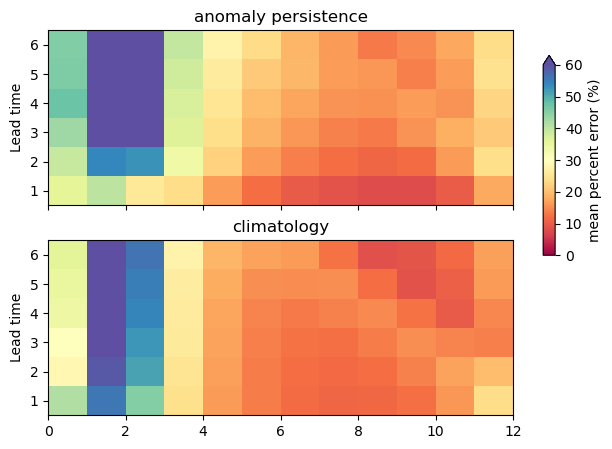

In [160]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6,5), sharex=True)

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

cax = axs[0].pcolormesh(x, y, 100 * persistence_error, cmap='Spectral', shading='flat', vmin=0, vmax=60)
axs[0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0].set_ylabel("Lead time")
axs[0].set_title(f"anomaly persistence")

axs[1].pcolormesh(x, y, 100 * climatology_error, cmap='Spectral', shading='flat', vmin=0, vmax=60)
axs[1].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1].set_ylabel("Lead time")
axs[1].set_title("climatology")

cbar_ax = fig.add_axes([0.95, 0.43, 0.02, 0.4])
plt.colorbar(cax, cax=cbar_ax, label=r'mean percent error (%)', orientation='vertical', extend='max')
#plt.savefig("figures/cesm/simple_vs_more-inputs_MPE.jpg", dpi=300, bbox_inches='tight')

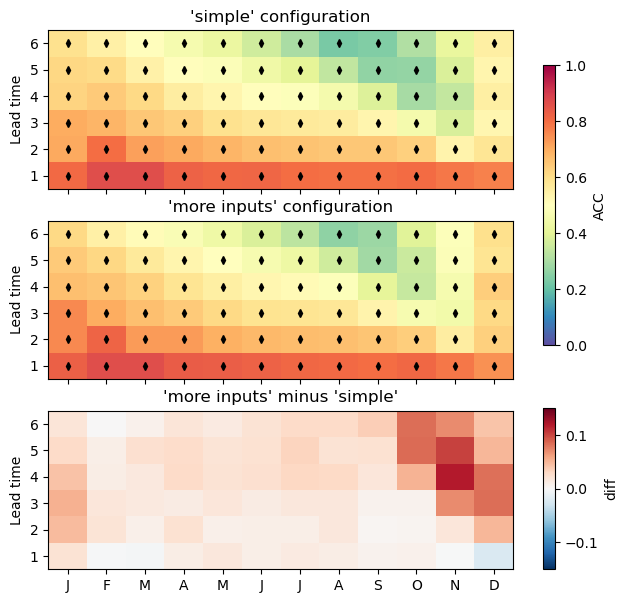

In [190]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6,7), sharex=True)

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

exceeds_persistence = model1_acc_spatial > persistence_acc_spatial
exceeds_climatology = model1_acc_spatial > climatology_acc_spatial
cax = axs[0].pcolormesh(x, y, model1_acc_spatial.T, cmap='Spectral_r', shading='flat', vmin=0, vmax=1)
axs[0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0].set_ylabel("Lead time")
axs[0].set_title(f"'simple' configuration")
plot_markers(axs[0], exceeds_persistence.T, exceeds_climatology.T, x_centers, y_centers)

exceeds_persistence = model2_acc_spatial > persistence_acc_spatial
exceeds_climatology = model2_acc_spatial > climatology_acc_spatial
axs[1].pcolormesh(x, y, model2_acc_spatial.T, cmap='Spectral_r', shading='flat', vmin=0, vmax=1)
axs[1].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1].set_ylabel("Lead time")
axs[1].set_title("'more inputs' configuration")
plot_markers(axs[1], exceeds_persistence.T, exceeds_climatology.T, x_centers, y_centers)

cax2 = axs[2].pcolormesh(x, y, (model2_acc_spatial - model1_acc_spatial).T, cmap='RdBu_r', shading='flat', vmin=-0.15, vmax=0.15)
axs[2].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
axs[2].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[2].set_ylabel("Lead time")
axs[2].set_title("'more inputs' minus 'simple'")


cbar_ax = fig.add_axes([0.95, 0.43, 0.02, 0.4])
cbar_ax2 = fig.add_axes([0.95, 0.11, 0.02, 0.23])
plt.colorbar(cax, cax=cbar_ax, label=r'ACC', orientation='vertical')
plt.colorbar(cax2, cax=cbar_ax2, label=r'diff', orientation='vertical')
plt.savefig("figures/cesm/simple_vs_more-inputs_ACC.jpg", dpi=300, bbox_inches='tight')